In [1]:
# Name Dipika Sharma
# DSC 530 T301 Data Exploration
# Week 10

# Assignment 10.2 - (12.1, 12.2)

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [7]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/mj-clean.csv")

Downloaded thinkstats2.py
Downloaded thinkplot.py
Downloaded mj-clean.csv


In [8]:
import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

## Exercise 12.1

Exercise 12.1 The linear model I used in this chapter has the obvious drawback that it is linear, and there is no reason to expect prices to change linearly
over time. We can add flexibility to the model by adding a quadratic term,
as we did in Section 11.3.
Use a quadratic model to fit the time series of daily prices, and use the model
to generate predictions. You will have to write a version of RunLinearModel
that runs that quadratic model, but after that you should be able to reuse
code in timeseries.py to generate predictions.

In [38]:
# Load the data from "Price of Weed"

dataframe = pd.read_csv("mj-clean.csv", parse_dates=[5])
dataframe.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


In [43]:
# Defining function which will take the dataframe, compute and returns the daily averages.

def GroupByDay(transactions, func=np.mean):

    grouped = transactions[["date", "ppg"]].groupby("date")
    daily = grouped.aggregate(func)

    daily["date"] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, "Y")
    daily["years"] = (daily.date - start) / one_year

    return daily

In [44]:
# Defining the function which will take the dataframe, divide the dataframe by quality variable and will returns a map from quality name of daily averages.

def GroupByQualityAndDay(transactions):
 
    groups = transactions.groupby("quality") # grouping by quality
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)

    return dailies

In [45]:
dailies = GroupByQualityAndDay(dataframe)

In [46]:
# Quadratic model to fit the time series of daily prices
# Defining function to take the dataframe which has daily prices group by quality. This function will returns the model and results.

def RunQuadraticModel(daily):
 
    daily["years2"] = daily.years**2
    model = smf.ols("ppg ~ years + years2", data=daily)
    results = model.fit()
    return model, results

In [47]:
# using statsmodels as a function of time to run a linear model of price.

import statsmodels.formula.api as smf

In [53]:
# Lets run the model for high quality cannabis.

quality_name = "high"
daily = dailies[quality_name]

model, results = RunQuadraticModel(daily)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Fri, 20 May 2022   Prob (F-statistic):          4.57e-164
Time:                        21:00:05   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6980      0.067    205.757      0.000      13.567      13.829
years         -1.1171      0.084    -13.326      0.000      -1.282      -0.953
years2         0.1132      0.022      5.060      0.000       0.069       0.157
==============================================================================
Omnibus:                       49.112   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.885
Skew:                           0.199   Prob(JB):                     1.86e-25
Kurtosis:                       4.430   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### As we can see the R-squared value is between 0 to 1 so the created model is a fit. The std err varialble is very low which means the selected model is accurate. The p-value is 0 which is considered to be statistically significant

In [50]:
# Now lets use the data to plot the fitted model.
# The following function will take the model, results and label as different variable. 

def PlotFittedValues(model, results, label=""):

    years = model.exog[:, 1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label="model", color="#ff7f00")

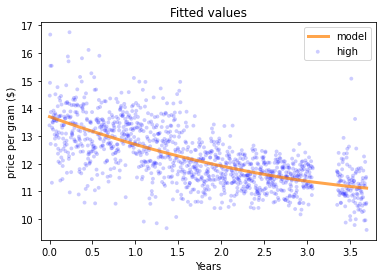

In [52]:
# Lets plot the data using fitted model.
# PlotFittedValues function will makes a scatter plot of the data points and a line plot of the fitted values

PlotFittedValues(model, results, label=name)
thinkplot.Config(
    title="Fitted values", xlabel="Years", xlim=[-0.1, 3.8], ylabel="price per gram ($)"
)

#### The above plot shows the results for high quality cannabis and the model looks like a fair liner fit for the data.

In [54]:
# Defining function RunLinearmodel to run the quadratic model

def RunLinearModel(daily):
    model = smf.ols("ppg ~ years", data=daily)
    results = model.fit()
    return model, results

In [55]:
# Defining function to plot predictions.
# This function will take dataframe, sequence of time in years, simulation, percentile range and function thats fits a model to the data.

def PlotPredictions(daily, years, iters=101, percent=90, func=RunLinearModel):

    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100 - p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color="gray")

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color="gray")

In [59]:
# defining function which will take dataframe, simulation and function that fits the model to the data.
# This function will run iters number of times and will return the list of result object.

def SimulateResults(daily, iters=101, func=RunLinearModel):

    _, results = func(daily)
    fake = daily.copy()

    result_seq = []
    for _ in range(iters):
        
        # Resampling to find out the uncertainty in the prediction. 
        # resamples from the residual to generate fake dataset.
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid) 
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

In [60]:
# Defining the function will take list of result object, sequence of times in years.
# Return the array of predicted value from the list of result object.
# add_resid is boolean variale which will take false when prediction represent sampling error and true then we include the resampled residuals to the predicted values.

def GeneratePredictions(result_seq, years, add_resid=False):
 
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)

    predict_seq = []
    for fake_results in result_seq:
        
        # Using predict method to generate predictions
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    # returning the sequence of predictions.
    return predict_seq

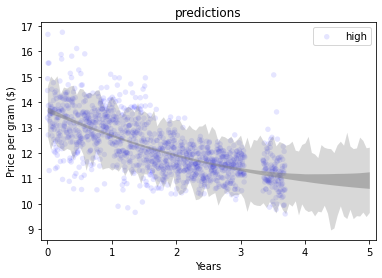

In [58]:
# Now lets plot the scatter plot to represent the sequence of prediction.

years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years, func=RunQuadraticModel)
thinkplot.Config(
    title="predictions",
    xlabel="Years",
    xlim=[years[0] - 0.1, years[-1] + 0.1],
    ylabel="Price per gram ($)",
)

#### The above plot show the prediction based on linear fits. it also show the variation is due to the sampling error and prediction error where dark gray area of plot represnt the 90% confidence interval for the sampling error which show the modeling uncertainty where as the lighter region represent the 90% confidence interval for prediction error meaning predictive uncertainty.


## Exercise 12.2

Exercise 12.2 Write a definition for a class named SerialCorrelationTest
that extends HypothesisTest from Section 9.2. It should take a series and
a lag as data, compute the serial correlation of the series with the given lag,
and then compute the p-value of the observed correlation.
Use this class to test whether the serial correlation in raw price data is
statistically significant. Also test the residuals of the linear model and (if
you did the previous exercise), the quadratic model

In [62]:
# Defining the class to perform the Hypothesis test
# this class will test whether the serial correlation is statistically significant or not by permutation.
# And also test the residual of the linear model.


class SerialCorrelationTest(thinkstats2.HypothesisTest):
 
    def TestStatistic(self, data):

        series, lag = data
        test_stat = abs(SerialCorr(series, lag))
        return test_stat

    def RunModel(self):
 
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag

In [63]:
# Defining the function, this will take series and lag as data, calculate the p value and returns the correlation.

def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

In [67]:
# Now lets test the corelation between consecutive prices and high quality category.

quality_name = "high"
daily = dailies[quality_name]

series = daily.ppg
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.4852293761947381 0.0


#### Since the serial correlation is 0.48 for the high quality category then for long-term we expect strong correlation.

In [68]:
# Lets find out the serial correlation in residuals of the linear model

_, results = RunLinearModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.07570473767506267 0.01


#### Serial correlation is 0.07 which is small. This indicate that there is not very strong correlation in this series.

In [70]:
# Now we look for serial correlation in residuals of the quadratic model

_, results = RunQuadraticModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.05607308161289921 0.043


#### Serial correlation is 0.05 which is small. This indicate that there is not very strong correlation in this series.